═════════════════ scikit-learn preprocessing example ═════════════════

Original dataset:


,age,salary,gender,country,purchased
0,25.0,45000.0,Male,Germany,0
1,32.0,62000.0,Female,France,1
2,999.0,38000.0,Female,Spain,0
3,45.0,NaN,Male,Germany,1
4,28.0,52000.0,NaN,France,0
5,60.0,89000.0,Male,Spain,1
6,36.0,71000.0,Female,NaN,1
7,NaN,NaN,Female,Germany,0
8,-5.0,145000.0,Male,France,1
9,29.0,48000.0,Female,Spain,0



Missing values:
age          1
salary       2
gender       1
country      1
purchased    0
dtype: int64

Preprocessing pipeline created ✓
Train shape: (7, 4)   Test shape: (3, 4)

Processed training data (first 5 rows):


,age,salary,gender_Male,country_Germany,country_Spain
3,-0.388,-0.167,1.0,1.0,0.0
9,-0.436,-0.750,0.0,0.0,1.0
2,2.448,-1.398,0.0,0.0,1.0
6,-0.415,0.741,0.0,0.0,1.0
5,-0.344,1.908,1.0,0.0,1.0


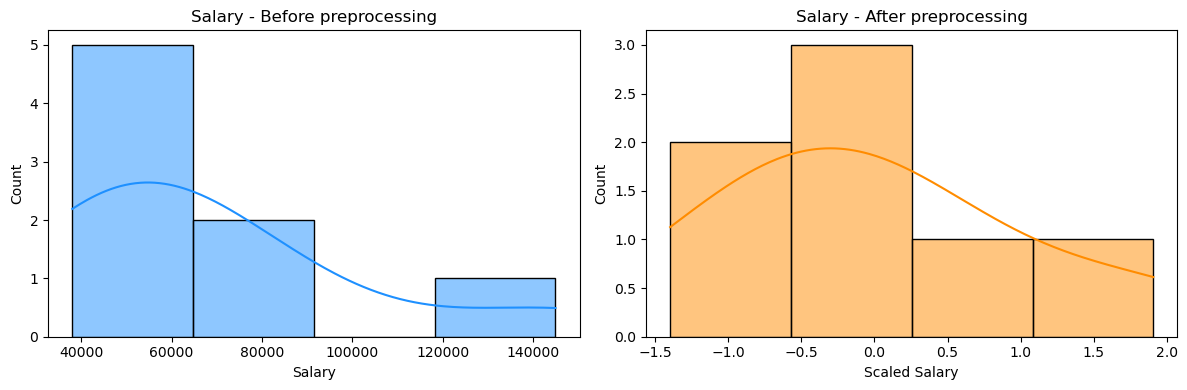

In [12]:
# Cell 1 - Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn preprocessing & model
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler, 
    OneHotEncoder, 
    OrdinalEncoder,
    RobustScaler
)

# We'll also create a small realistic-looking sample dataset
print(" scikit-learn preprocessing example ".center(70, "═"))

# ────────────────────────────────────────────────
# Cell 2 - Create sample dataset (mimics real-world messy data)
# ────────────────────────────────────────────────

data = {
    'age': [25, 32, np.nan, 45, 28, 60, 36, np.nan, 52, 29],
    'salary': [45000, 62000, 38000, np.nan, 52000, 89000, 71000, 42000, 145000, 48000],
    'gender': ['Male', 'Female', 'Female', 'Male', np.nan, 'Male', 'Female', 'Female', 'Male', 'Female'],
    'country': ['Germany', 'France', 'Spain', 'Germany', 'France', 'Spain', np.nan, 'Germany', 'France', 'Spain'],
    'purchased': [0, 1, 0, 1, 0, 1, 1, 0, 1, 0]   # target
}

df = pd.DataFrame(data)
df.loc[7, 'salary'] = np.nan          # extra missing value
df.loc[2, 'age'] = 999                # unrealistic outlier
df.loc[8, 'age'] = -5                 # invalid value

print("\nOriginal dataset:")
display(df)
print("\nMissing values:")
print(df.isna().sum())

# ────────────────────────────────────────────────
# Cell 3 - Define numerical & categorical columns
# ────────────────────────────────────────────────

numeric_features = ['age', 'salary']
categorical_features = ['gender', 'country']

# ────────────────────────────────────────────────
# Cell 4 - Create preprocessing pipelines
# ────────────────────────────────────────────────

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),     # or 'mean'
    ('outlier_handler', RobustScaler()),               # helps with extreme values
    ('scaler', StandardScaler())                       # or MinMaxScaler()
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    # You could also use OrdinalEncoder() for tree-based models
])

# Combine them using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'   # if you had columns you don't want to touch
)

print("\nPreprocessing pipeline created ✓")

# ────────────────────────────────────────────────
# Cell 5 - Split data & apply preprocessing
# ────────────────────────────────────────────────

X = df.drop('purchased', axis=1)
y = df['purchased']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}   Test shape: {X_test.shape}")

# Fit & transform
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed  = preprocessor.transform(X_test)

# ────────────────────────────────────────────────
# Cell 6 - Nice visualization of the result
# ────────────────────────────────────────────────

# Get feature names after transformation
cat_ohe_names = preprocessor.named_transformers_['cat']\
                             .named_steps['encoder']\
                             .get_feature_names_out(categorical_features)

all_feature_names = numeric_features + list(cat_ohe_names)

print("\nProcessed training data (first 5 rows):")
processed_df = pd.DataFrame(
    X_train_processed,
    columns=all_feature_names,
    index=X_train.index
).round(3)

display(processed_df.head())

# Optional: compare distributions before vs after
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(df['salary'], kde=True, color='dodgerblue')
plt.title("Salary - Before preprocessing")
plt.xlabel("Salary")

plt.subplot(1, 2, 2)
sns.histplot(processed_df['salary'], kde=True, color='darkorange')
plt.title("Salary - After preprocessing")
plt.xlabel("Scaled Salary")

plt.tight_layout()
plt.show()